In [9]:
import cv2
import numpy as np
from typing import TypeAlias
import matplotlib.pyplot as plt
from pycubing.enums import Color
from math import sqrt, atan, degrees

In [10]:
MAX_IMG_AREA = 2_500_000

Contour: TypeAlias = np.ndarray
Point: TypeAlias = np.ndarray

def imshow(*imgs: cv2.Mat) -> None:
    def helper(img: cv2.Mat) -> None:
        plt.axis('off')
        plt.grid(False)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        plt.show()
    for img in imgs:
        helper(img)

def imread_capped(filename: str) -> cv2.Mat:
    img = cv2.imread(filename)
    scale_factor = min(sqrt(MAX_IMG_AREA / (img.shape[0] * img.shape[1])), 1)
    return cv2.resize(img, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

def to_hsv(img: cv2.Mat):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def from_hsv(img: cv2.Mat):
    return cv2.cvtColor(img, cv2.COLOR_HSV2BGR) 

Remove shadows to make HSV filtering a little easier

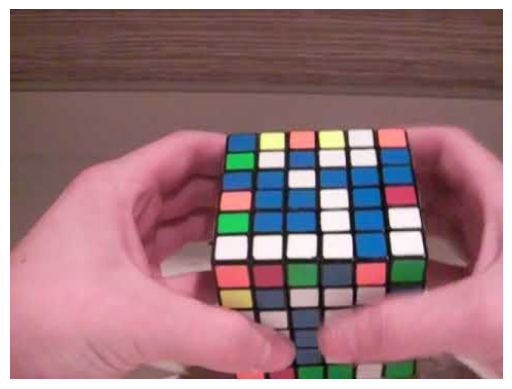

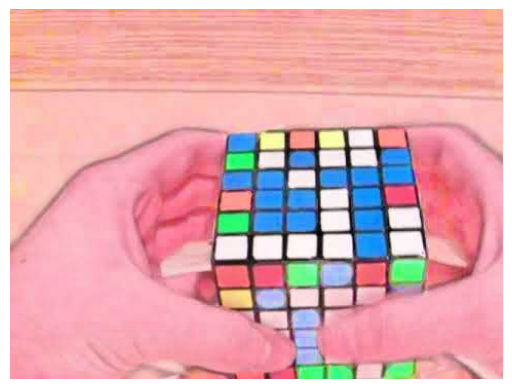

In [38]:
def get_extreme_diff(channel: np.ndarray) -> np.ndarray:
    dilated = cv2.dilate(channel, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
    bg = cv2.medianBlur(dilated, 21)
    diff = 255 - cv2.absdiff(channel, bg) 
    return cv2.normalize(diff, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

def remove_shadows(img: cv2.Mat) -> cv2.Mat:
    hsv_img = to_hsv(img)
    h, s, v = cv2.split(hsv_img)
    new_img = cv2.merge([h, s, get_extreme_diff(v)])
    return from_hsv(new_img)

img = cv2.imread("./images/6x6_other.png")
imshow(img, remove_shadows(img))

Apply HSV filtering for each color

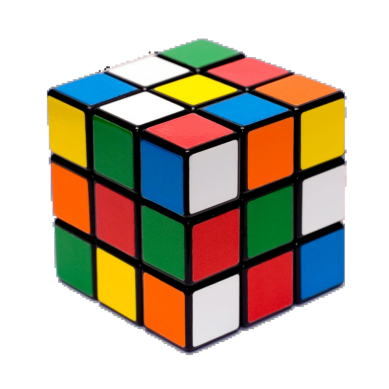

Color.RED : 


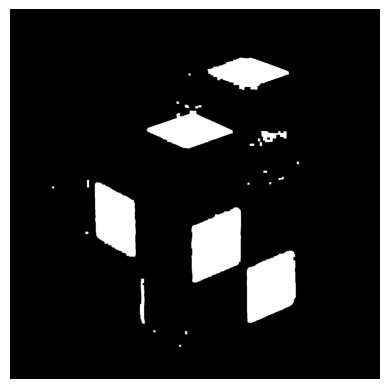

Color.ORANGE : 


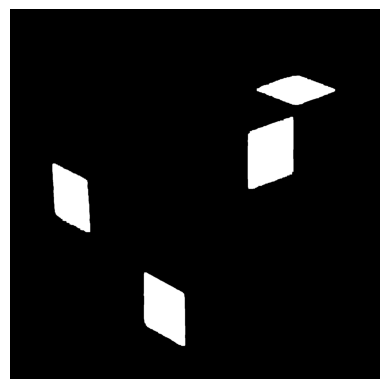

Color.BLUE : 


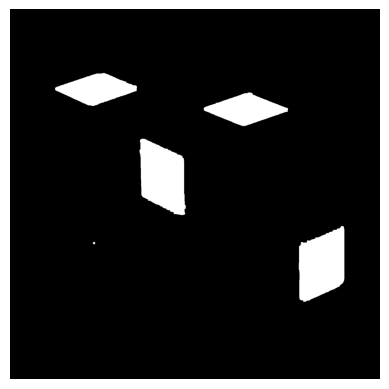

Color.GREEN : 


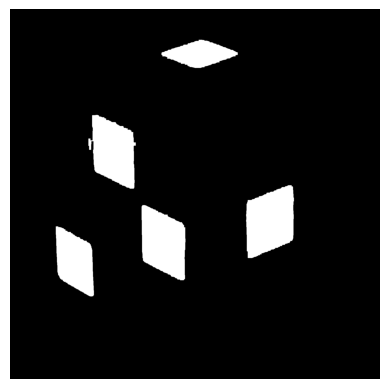

Color.WHITE : 


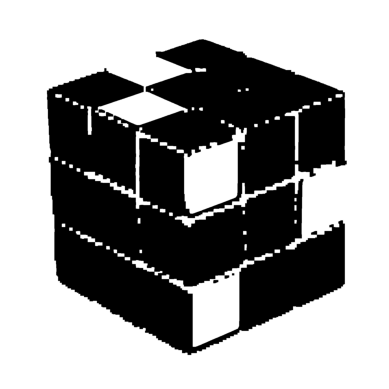

Color.YELLOW : 


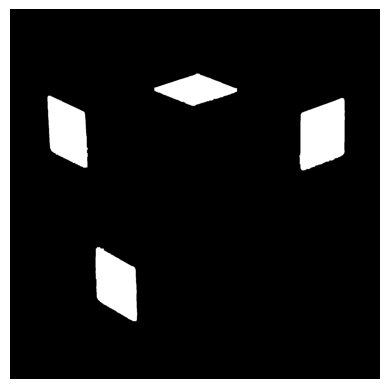

In [81]:
HSV_FILTER_COLORS = {
    Color.RED: (((170, 180), (0, 10)), (100, 255), (100, 255)),
    Color.ORANGE: (((10, 20),), (100, 255), (100, 255)),
    Color.BLUE: (((95, 125),), (100, 255), (100, 255)),
    Color.GREEN: (((40, 75),), (50, 255), (50, 255)),
    Color.WHITE: (((0, 180),), (0, 50), (150, 255)),
    Color.YELLOW: (((20, 35),), (100, 255), (100, 255)),
}

def get_hsv_masks(img: cv2.Mat) -> dict[Color, cv2.Mat]:

    def bitwise_or(*arrs: cv2.Mat):
        result = arrs[0]
        for arr in arrs[1:]:
            result = cv2.bitwise_or(arr, result)
        return result
    
    def transform_mask(mask: cv2.Mat):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
        opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        return cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    
    hsv_img = to_hsv(img)

    return {
        c: transform_mask(bitwise_or(*[
            cv2.inRange(hsv_img, *zip(h, s, v))
            for h in h_ranges
        ])) for c, (h_ranges, s, v) in HSV_FILTER_COLORS.items() 
    }

img = cv2.imread("./images/cube.png")
imshow(img)
for c, mask in get_hsv_masks(remove_shadows(img)).items():
    print(c, ": ")
    imshow(mask)

In [44]:
[i for i in dir(cv2) if type(getattr(cv2, i)) == type(cv2.inRange)]

['AKAZE_create',
 'AffineFeature_create',
 'AgastFeatureDetector_create',
 'BFMatcher_create',
 'BRISK_create',
 'CV_16FC',
 'CV_16SC',
 'CV_16UC',
 'CV_32FC',
 'CV_32SC',
 'CV_64FC',
 'CV_8SC',
 'CV_8UC',
 'CV_MAKETYPE',
 'CamShift',
 'Canny',
 'CascadeClassifier_convert',
 'DISOpticalFlow_create',
 'DescriptorMatcher_create',
 'EMD',
 'FaceDetectorYN_create',
 'FaceRecognizerSF_create',
 'FarnebackOpticalFlow_create',
 'FastFeatureDetector_create',
 'FlannBasedMatcher_create',
 'GFTTDetector_create',
 'GaussianBlur',
 'HOGDescriptor_getDaimlerPeopleDetector',
 'HOGDescriptor_getDefaultPeopleDetector',
 'HoughCircles',
 'HoughLines',
 'HoughLinesP',
 'HoughLinesPointSet',
 'HoughLinesWithAccumulator',
 'HuMoments',
 'KAZE_create',
 'KeyPoint_convert',
 'KeyPoint_overlap',
 'LUT',
 'Laplacian',
 'MSER_create',
 'Mahalanobis',
 'ORB_create',
 'PCABackProject',
 'PCACompute',
 'PCACompute2',
 'PCAProject',
 'PSNR',
 'QRCodeEncoder_create',
 'RQDecomp3x3',
 'Rodrigues',
 'SIFT_create',
 '

Find the squares in which everything is

480 10 2


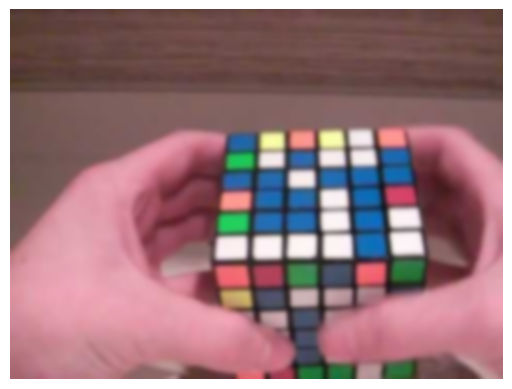

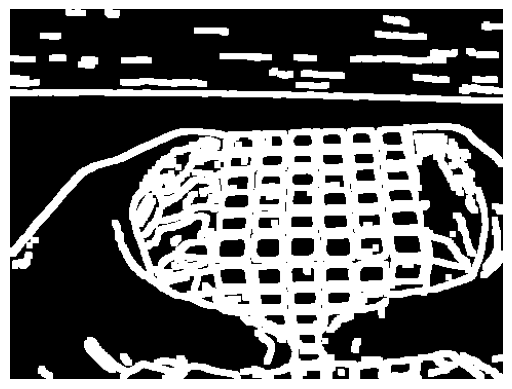

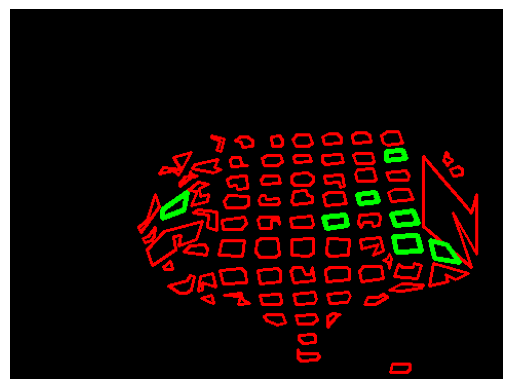

In [30]:
def filter_cubie_contours(img: cv2.Mat, contours: list[Contour], approx: list[Contour]) -> list[Contour]:

    # filter erradic, non-quadrilateral contours
    proper_contours, proper_approx = [], []
    for cnt, appr in zip(contours, approx):

        # make sure the shape approximation is a quadrilateral 
        D = len(appr) * 2
        if not 8==D:  # lol
            continue

        # make sure the approx isnt crazy different area-wise - consider removing this test
        cnt_area = cv2.contourArea(cnt, True)
        ratio = cnt_area / cv2.contourArea(appr, True)
        if min(ratio, 1/ratio) < 0.80:   # artitrary ratio thresold chosen by me
            continue

        # make sure the overlapping area isnt too bad
        overlap_reference = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.drawContours(overlap_reference, [cnt], -1, (255, 255, 255), cv2.FILLED)
        cv2.drawContours(overlap_reference, [appr], -1, (0, 0, 0), cv2.FILLED)
        if (overlap_reference.sum() // 255) > (cnt_area // 5):
            continue

        proper_contours.append(cnt) 
        proper_approx.append(appr)

    # sweep through it again and cut off the ones that are too small
    avg_area = np.average([*map(cv2.contourArea, proper_approx)])
    return [*filter(lambda x: cv2.contourArea(x) > avg_area / 4, proper_approx)]

def get_cubie_contours(img: cv2.Mat, show: bool = False) -> list[Contour]:

    # computes some sizes - doesn't get too crazy because sizes are standardized
    reference_size = max(img.shape)
    blur_size = int(sqrt(reference_size) / 2)
    kernel_size = int(sqrt(reference_size) / 10)
    if show:
        print(reference_size, blur_size, kernel_size)

    # image processing to get contours
    blur = cv2.GaussianBlur(img, (blur_size + int(blur_size % 2 == 0),) * 2, kernel_size)
    edges = cv2.Canny(blur, 20, 30)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size * 3,) * 2)
    dilated = cv2.dilate(edges, kernel)
    contours = sorted(cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0], key=cv2.contourArea, reverse=True)
    large_contours = [*filter(lambda x: cv2.contourArea(x, True) > (img.shape[0] * img.shape[1]) // 5000, contours)]
    approx = [*map(lambda x: cv2.approxPolyDP(x, 0.03*cv2.arcLength(x, True), True), large_contours)]
    
    # filter the contours, show if needed
    filtered = filter_cubie_contours(img, large_contours, approx)
    if show:
        display_image = np.zeros_like(img)
        cv2.drawContours(display_image, approx, -1, (0, 0, 255), 2)
        cv2.drawContours(display_image, filtered, -1, (0, 255, 0), 3)
        imshow(blur, dilated, display_image)
    return filtered, approx

img = imread_capped("./images/6x6_other.png")
_ = get_cubie_contours(img, show=True)

Split the small cubies by face, in order to better determine where everything is - this works optimally when the cube has three faces on display, as all three have different angles.

/var/folders/kn/r_ns995d0zbctydtk4vjdlw80000gn/T/ipykernel_5827/3542532313.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  return degrees(atan(y_diff / x_diff))


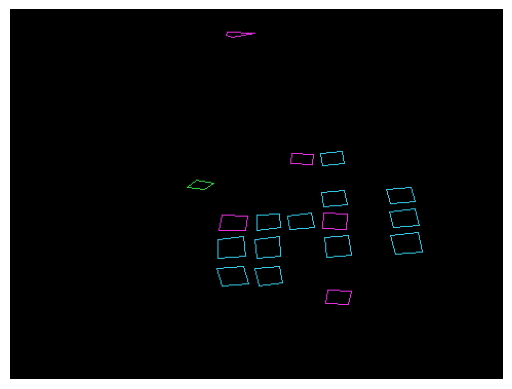

In [28]:
def get_squares_by_angle(squares: list[Contour]):

    ANGLE_DIFF_TOLERANCE = 18   # degrees
    def compute_incline_angle(c1: np.ndarray[int, int], c2: np.ndarray[int, int]):
        """ Helper function to compute the angle between two corners. """
        x_diff, y_diff = map(abs, (c1[0] - c2[0], c1[1] - c2[1]))
        return degrees(atan(y_diff / x_diff))

    angle_to_squares = {}
    for appr in squares:
        appr = appr.reshape(appr.shape[0], 2)
        corner1, corner2, corner3 = appr[0], appr[1], appr[-1]
        angle_of_incline1 = compute_incline_angle(corner1, corner2)
        angle_of_incline2 = compute_incline_angle(corner3, corner1)
        for (k1, k2), v in angle_to_squares.items():
            if abs(angle_of_incline1 - k1) < ANGLE_DIFF_TOLERANCE and abs(angle_of_incline2 - k2) < ANGLE_DIFF_TOLERANCE:   
                v.append(appr)
                break
        else:
            angle_to_squares[(angle_of_incline1, angle_of_incline2)] = [appr]
    return angle_to_squares

img = imread_capped("./images/6x6_other.png")
display_img = np.zeros_like(img)
for i, v in enumerate(get_squares_by_angle(get_cubie_contours(img, show=False)[0]).values()):
    colors = ((235, 204, 52), (226, 49, 232), (65, 217, 48), (0, 0, 200))
    cv2.drawContours(display_img, v, -1, colors[min(i, 3)], max(display_img.shape) // 1000 + 1)
imshow(display_img)

Considering restricting input to only allow for three-sided images

In [47]:
def get_face_color(p: Point) -> Color | None:
    pass
    # make sure we are not reading the background or something

def rotate_face_to_square(squares: list[Contour]):
    """ 
    Determine the four extreme of the cube and apply a four-point-transform to the contours.
    """
    

def get_face_squares(face_contours: dict[tuple[float], list[Contour]]) -> tuple[str, list[Point]]:
    for face, squares in face_contours.items():
        extreme_corner = min(squares, key=lambda x: min())
        

2583263

In [1]:
import time
img = cv2.imread("./images/cube_ugly.png")
blur = cv2.GaussianBlur(img, (21, 21), 5)
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
imshow(*map(lambda x: cv2.bitwise_not(cv2.Canny(x, 20, 30)), [blur, gray]))

# start = time.perf_counter()
# edges = cv2.Canny(blur, 20, 30)
# end1 = time.perf_counter()
# thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 1)
# adjusted_thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
# end2 = time.perf_counter()
# imshow(cv2.bitwise_not(edges), adjusted_thresh)
# print(end1-start, end2-end1)

NameError: name 'cv2' is not defined

000001011110110010100010000000111110101001010100100100101000000000110000111010101010010111101110000000110100101010101101000000010110101001101100111100011100000000101010111001100010111010000000011110110010100010000000111000100000101011101111000000100110101010110110
000001011110110010100010000000111110101001010100100100101000000000110000111010101010010111101110000000110100101010101101000000010110101001101100111100011100000000101010111001100010111010000000011110110010100010000000111000100000101011101111000000100110101010110110
